# Radial Distribution Function (RDF)

This notebook will demonstrate how to calculate the RDF of a gsd trajectory from a hoomd simulation, discuss how to interpret the RDF, and allow users to use the RDF to determine the phase transition temperature.

Many images shown in this tutorial were found in the open textbook [Molecular Simulation](https://en.wikibooks.org/wiki/Molecular_Simulation), a useful introduction.

In [1]:
import freud
import gsd
import hoomd
import matplotlib.pyplot as plt

from utils.cg_utils import gsd_rdf
from utils.draw_scene import snap_render, display_movie, from_gsd

plt.rcParams['figure.figsize'] = 9.0, 6.0
plt.rcParams['font.size'] = 18

In [2]:
def rdf_from_gsd(gsd_file, r_max=None, r_min=0.1, nbins=50, start=0):
    f = gsd.pygsd.GSDFile(open(gsd_file, "rb"))
    trajectory = gsd.hoomd.HOOMDTrajectory(f)
    
    if r_max is None:
        r_max = max(trajectory[0].configuration.box[:3]) * 0.45
    freud_rdf = freud.density.RDF(bins=nbins, r_max=r_max, r_min=r_min)
    for frame in trajectory[start:]:
        freud_rdf.compute(system=frame, reset=False)
    return freud_rdf

Our simulations use periodic boundary conditions, so we can simulate an "infinite" volume with a minimal amount of particles (think pac-man rules). We do this to minimize the effect of interfaces (e.g., surface of water) because they have different properties than the bulk. In a molecular dynamics simulation, each particle has a position and momentum. If we consider these for ALL particles in the system, that describes the microstate of the system. The RDF is caculated using just the positions of all particles.

The RDF tells us the probability (normalized by the density of the system and volume of the shell swept out by that radius) of finding a particle at distance r from any other particle.

The RDF algorithm goes like this:
1. Get a histogram of distances between particles
    1. Loop over all N particles
    2. Calculate the distance between each particle and all its neighbors
    3. Group the distances in "bins". (e.g., choose a step size, dr. If a distance is between $0 \times dr$ and $1 \times dr$, it goes in the first bin; a distance between $1 \times dr$ and $2 \times dr$ goes in the second bin, etc.)
2. Normalize the histogram by dividing by the total number of pairs ($N\times(N-1)$), the number density ($\rho = \frac{N}{V}$) and the volume of the spherical shell. This is important because it allows us to compare RDFs.

The RDF plot will have the RDF (sometimes called $g(r)$ or $g_{2}(r)$ for "pairwise correlation function" [[1](#footnote1)]) on the y-axis and r (distance) on the x-axis. 

<a id="footnote1"></a>

[1] There are other correlation functions like $g_{3}$, $g_{4}$, that measure stuff like "if you have two particles this distance apart, what's the likelihood of having a 3rd particle this far away from the first one", etc, etc

### Initial structure and RDF

In the cell below, we compare a perfect BCC crystal structure with its RDF. The function `from_gsd` loads a gsd file and creates an `mbuild.Compound` of a specified frame.

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

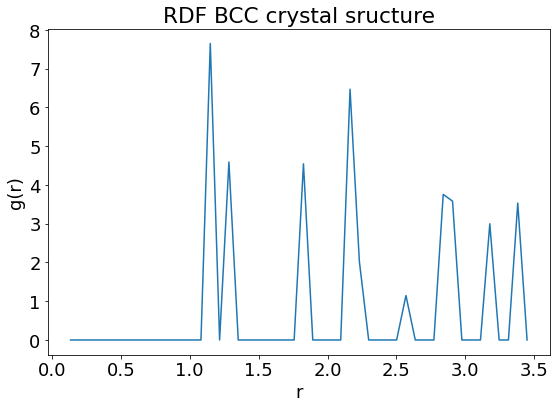

In [3]:
gsdfile = 'trajectories/bcc_system.gsd'

bcc_start = from_gsd(gsdfile, frame=0)

bcc_start.visualize().show()
    

bcc_start_rdf = rdf_from_gsd(gsdfile)

plt.plot(bcc_start_rdf.bin_centers, bcc_start_rdf.rdf)
plt.title("RDF BCC crystal sructure")
plt.xlabel("r")
plt.ylabel("g(r)")
plt.show()

In the above plot, r is the distance between particles and g(r) is the probability of finding a neighboring particle at that distance. Examining the RDF plot, we see sharp, distinct peaks; because the structure is crystalline, there are only a few nearest neighbor distances, as shown in the image below:

![](https://www.princeton.edu/~maelabs/mae324/glos324/b109.gif)

Image credit [Princeton University](https://www.princeton.edu/~maelabs/mae324/glos324/nearestneighbor.htm)

Next we'll look at computing the accumulated RDF of a simulation trajectory. But before we do that, we need to know a little about these trajectories. The trajectories used in this tutorial were generated using the `build_system` and `hoomd_simulation` functions (shown below). These functions initialize a BCC or FCC system to run in the [NVT (Canonical) ensemble](https://en.wikibooks.org/wiki/Molecular_Simulation/Thermodynamic_ensembles) using the [Lennard-Jones potential](https://en.wikibooks.org/wiki/Molecular_Simulation/The_Lennard-Jones_Potential).

Lennard-Jones is a pairwise potential which decribes the attractive or repulsive force between two particles. If the slope of the potential is positive, the particles be attracted; if it is negative, they will be repulsed.

![](https://gifsdefisicacom.files.wordpress.com/2018/12/0184giphy.gif)

Image credit [GIFs de Física](https://gifsdefisica.com/2018/12/18/potencial-de-lennard-jones/)

This potential is controlled mainly by two parameters, epsilon and sigma:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/fe/Schematic_of_the_Lennard-Jones_6-12_Potential.png/1024px-Schematic_of_the_Lennard-Jones_6-12_Potential.png" width=300 />

Image credit [Christopher Rowley](https://commons.wikimedia.org/w/index.php?curid=44617468)

Where epsilon, the depth of the potential well, controls the strength of attraction between two particles and sigma, the distance where the potential is zero, controls the effective particle size. Notice in the `hoomd_simulation` function the epsilon and sigma values in the [LJ force](https://hoomd-blue.readthedocs.io/en/stable/module-md-pair.html#hoomd.md.pair.lj) are set to 1:
```
lj.pair_coeff.set('C', 'C', epsilon=1.0, sigma=1.0)
```
The trajectories provided in this tutorial were run at kT = 0.25 (cold), 1.5 (mid), and 5 (hot). You might wonder how to determine whether a [unitless temperature](https://hoomd-blue.readthedocs.io/en/stable/units.html) is cold or hot, and in this case we can think of the temperature (the thermal kinetic energy) as relative to the potentials the particles experience. In this case a "cold" simulation (kT=0.25) does not have enough kinetic energy to escape the attractive potential of a neighboring particle (epsilon=1).

In [4]:
def build_system(packing='bcc'):
    '''
    Generate a simple LJ particle system using hoomd's create_lattice function
    packing 
    '''
    if packing == 'fcc':
        system = hoomd.init.create_lattice(unitcell=(hoomd.lattice.fcc(a=1.58)), n=6)
    elif packing == 'bcc':
        system = hoomd.init.create_lattice(unitcell=(hoomd.lattice.bcc(a=1.29)), n=6)
    hoomd.dump.gsd('{}_system.gsd'.format(packing), group = hoomd.group.all(), period=None, overwrite=True)
    return system


def hoomd_simulation(packing, temp):  
    hoomd.context.initialize("")
    system = build_system(packing)
    nl = hoomd.md.nlist.cell()
    lj = hoomd.md.pair.lj(r_cut=2.5, nlist=nl)
    lj.pair_coeff.set('C', 'C', epsilon=1.0, sigma=1.0)
    hoomd.md.integrate.mode_standard(dt=0.001)
    _all = hoomd.group.all()
    nvt = hoomd.md.integrate.nvt(group=_all, kT=temp, tau=1)
    nvt.randomize_velocities(seed=23)
    hoomd.analyze.log(filename='out.log',
                      quantities=["time", "temperature", "potential_energy"],
                      period=100,
                      overwrite=True
                     )
    hoomd.dump.gsd('{}-{}kT-trajectory.gsd'.format(packing, temp), period=5e3, group=_all, overwrite=True)
    hoomd.run(3e5)

With that understanding, let's look at the "cold" system. (We'll use the `start` argument to skip the first 10 frames of the trajectory--this will help show the influence of temperature by minimizing the influence of the initial configuration.)

Cold system:

![cold](images/cold.gif)

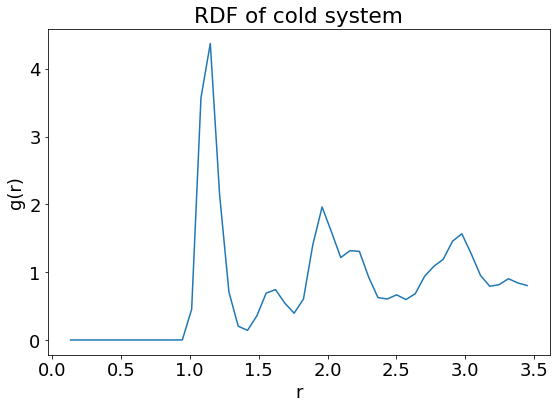

In [5]:
gsdfile = 'trajectories/bcc-cold.gsd'
    
bcc_cold_rdf = rdf_from_gsd(gsdfile, start=10)

plt.plot(bcc_cold_rdf.bin_centers, bcc_cold_rdf.rdf)
plt.title("RDF of cold system")
plt.xlabel("r")
plt.ylabel("g(r)")
plt.show()

The RDF can tell us about the [phase](https://en.wikipedia.org/wiki/Phase_(matter)) of a system. A solid will have sharp, distinct peaks, a liquid will have smooth, continuous peaks, and a gas may only have one peak and most values of g(r) are close to 1.

![](https://upload.wikimedia.org/wikipedia/commons/b/b8/Simulated_Radial_Distribution_Functions_for_Solid%2C_Liquid%2C_and_Gaseous_Argon.svg)

Image credit [Christopher Rowley](https://commons.wikimedia.org/w/index.php?curid=44617468)

Looking at the system and the RDF, we can see that the particles have not moved too much from their starting positions and the system is still semi-crystalline as determined by the distinct sharp peaks. But as the particles move around, those peaks begin to broaden.

Let's look at the warmer trajectory (kT=1.5, epsilon=1).

Mid system:

![](images/mid.gif)

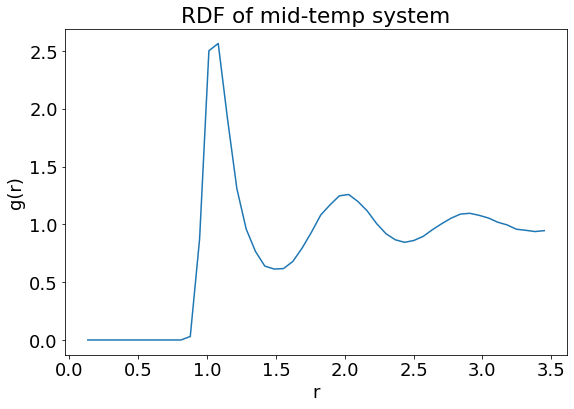

In [6]:
gsdfile = 'trajectories/bcc-mid.gsd'

bcc_mid_rdf = rdf_from_gsd(gsdfile, start=10)
plt.plot(bcc_mid_rdf.bin_centers, bcc_mid_rdf.rdf)
plt.title("RDF of mid-temp system")
plt.xlabel("r")
plt.ylabel("g(r)")
plt.show()

As the temperature is increased, the peaks begin to smooth out and the system looks much more random. 

Finally, let's look at the "hot" (kT=5, epsilon=1) trajectory.

Hot system:

![](images/hot.gif)

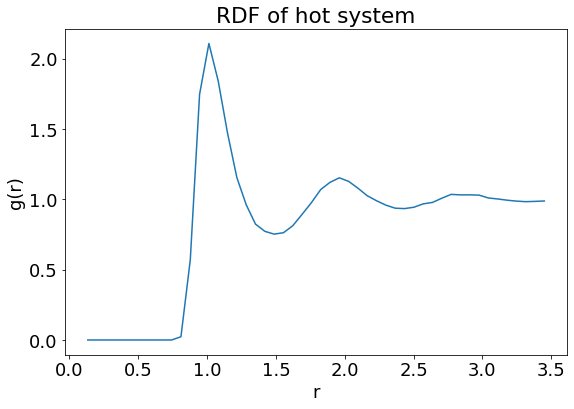

In [7]:
gsdfile = 'trajectories/bcc-hot.gsd'

bcc_hot_rdf = rdf_from_gsd(gsdfile, start=10)

plt.plot(bcc_hot_rdf.bin_centers, bcc_hot_rdf.rdf)
plt.title("RDF of hot system")
plt.xlabel("r")
plt.ylabel("g(r)")
plt.show()

Again the peaks are even smoother and the system configuration looks very random.

Next, in the cells below, try running your own experiments using `hoomd_simulation`. (simulation time ~ 2min) Try to determine the phase transition temperature between solid (rdf with sharp peaks) and liquid (rdf with smooth continuous peaks). Or try changing the initial configuration to "fcc" to see how the rdf changes. 

(replace `INPUT_TEMP` and `INPUT_PACKING` with your own values.)

In [ ]:
temp = INPUT_TEMP
packing = INPUT_PACKING    # "fcc" or "bcc"

hoomd_simulation(packing,temp)

The cell below will plot the RDF.

In [ ]:
gsdfile = f"{packing}-{temp}kT-trajectory.gsd"

my_rdf = rdf_from_gsd(gsdfile, start=10)

plt.plot(my_rdf.bin_centers, my_rdf.rdf)
plt.title(f"RDF of {packing} system kT={temp}")
plt.xlabel("r")
plt.ylabel("g(r)")
plt.show()

The cell below will visualize your system. (takes a minute)

In [ ]:
display_movie(snap_render, gsdfile)